In [15]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation , PReLU
from sklearn.metrics import accuracy_score


In [16]:
from numpy.random.mtrand import seed
from PIL import Image
import tensorflow as tf
import random as rn
import shutil
import cv2
import os

tf.keras.utils.set_random_seed(1)

# Split the dataset into Train, Test, Validation
I've used an 80-10-10 split, meaning 80% of the data goes to the training set, 10% to the testing set, and 10% to the validation set

In [17]:
# Define the main dataset directory
main_dataset_dir = 'Dataset'

# Define the directories for training, testing, and validation sets
train_dir = 'Dataset/train'
test_dir = 'Dataset/test'
val_dir = 'Dataset/validation'

# Create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [18]:
def split_data(source, train, test, validation, split_size):
    files = os.listdir(source)
    rn.shuffle(files)
    
    train_files = files[:int(len(files) * split_size)]
    test_files = files[int(len(files) * split_size):int(len(files) * (split_size + (1 - split_size) / 2))]
    val_files = files[int(len(files) * (split_size + (1 - split_size) / 2)):]

    for filename in train_files:
        shutil.copy(os.path.join(source, filename), os.path.join(train, filename))

    for filename in test_files:
        shutil.copy(os.path.join(source, filename), os.path.join(test, filename))

    for filename in val_files:
        shutil.copy(os.path.join(source, filename), os.path.join(validation, filename))



In [19]:
# Set the split ratio for train, test, and validation
split_size = 0.8  # You can try different values here, such as 0.7, 0.8, etc.

# Split the Cats dataset
cats_source = os.path.join(main_dataset_dir, 'Cats')
cats_train = os.path.join(train_dir, 'Cats')
cats_test = os.path.join(test_dir, 'Cats')
cats_val = os.path.join(val_dir, 'Cats')


split_data(cats_source, cats_train, cats_test, cats_val, split_size)

# Split the Dogs dataset
dogs_source = os.path.join(main_dataset_dir, 'Dogs')
dogs_train = os.path.join(train_dir, 'Dogs')
dogs_test = os.path.join(test_dir, 'Dogs')
dogs_val = os.path.join(val_dir, 'Dogs')
split_data(dogs_source, dogs_train, dogs_test, dogs_val, split_size)

In [20]:

def is_image_file(filename):
    return filename.lower().endswith(('.jpg', '.jpeg', '.png'))

def load_images_from_directory(directory, image_size=(180, 180)):
    images = []
    labels = []

    for class_name in os.listdir(directory):
        class_directory = os.path.join(directory, class_name)
        if os.path.isdir(class_directory):
            class_label = 0 if class_name == 'Cats' else 1  # Assign class labels (0 for Cats, 1 for Dogs)

            for filename in os.listdir(class_directory):
                if is_image_file(filename):
                    image_path = os.path.join(class_directory, filename)
                    image = Image.open(image_path)
                    image = image.resize(image_size)  # Resize the image to a fixed size
                    image_array = np.array(image)
                    images.append(image_array)
                    labels.append(class_label)

    return np.array(images), np.array(labels)

In [21]:

x_train, y_train = load_images_from_directory(train_dir)
x_test, y_test = load_images_from_directory(test_dir)
x_val, y_val = load_images_from_directory(val_dir)


# Exploring the Data
At first we will see how our samples are built.
We will see what are the size of the images, and in what dimension are they.

In [22]:

print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)

print('Shape of x_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)

print('Shape of x_val is:', x_val.shape)
print('Shape of y_val is:', y_val.shape)


Shape of x_train is: (8000, 180, 180, 3)
Shape of y_train is: (8000,)
Shape of x_test is: (1000, 180, 180, 3)
Shape of y_test is: (1000,)
Shape of x_val is: (1000, 180, 180, 3)
Shape of y_val is: (1000,)


In [23]:
np.min(x_train), np.max(x_train), x_train.dtype


(0, 255, dtype('uint8'))

###### As we can see above are data is 180*180 pixels, when each pixel presented by RGB means 3-d. We will normalize the values by split each of the RGB diemensions by 3.

In [24]:

x_train = x_train / 255.0
x_test = x_test / 255.0

In [25]:
np.min(x_train), np.max(x_train), x_train.dtype


(0.0, 1.0, dtype('float64'))

# Plot Labels representation



In [26]:
def plot_random_samples(x, y):
  plt.figure()

  f, axarr = plt.subplots(2, 2, gridspec_kw={'hspace':0.4}) 
  rands = np.random.randint(x.shape[0], size=4)
  axarr[0, 0].imshow(x[rands[0], :, :])
  axarr[0, 0].set_title('Label: ' + str(y[rands[0]]), fontweight='bold')

  axarr[1, 0].imshow(x[rands[1], :, :])
  axarr[1, 0].set_title('Label: ' + str(y[rands[1]]), fontweight='bold')

  axarr[0, 1].imshow(x[rands[2], :, :])
  axarr[0, 1].set_title('Label: ' + str(y[rands[2]]), fontweight='bold')

  axarr[1, 1].imshow(x[rands[3], :, :])
  axarr[1, 1].set_title('Label: ' + str(y[rands[3]]), fontweight='bold')

  plt.show()

     

<Figure size 640x480 with 0 Axes>

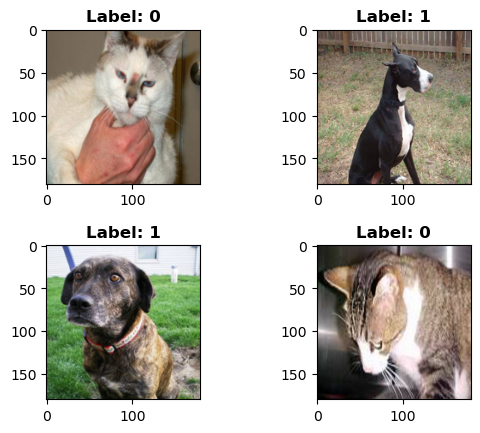

In [27]:
plot_random_samples(x_train, y_train)

<Figure size 640x480 with 0 Axes>

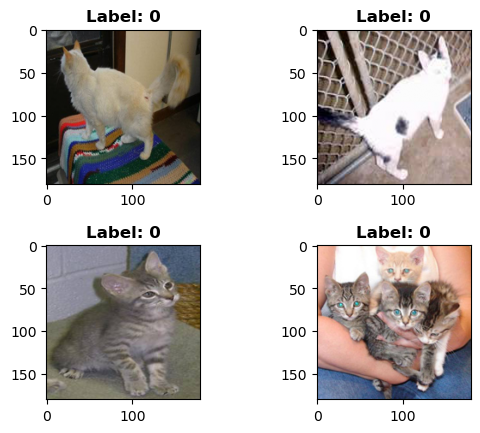

In [28]:
plot_random_samples(x_test, y_test)


# CNN model
Stracture -
Four 2d convolutional layers, were between each convolutional layer we added MaxPolling.
Flatten() - before the fully connected layers.
Followed by two fully connected layer (one hidden layer and one output layer)
We added dropout before the first hidden layer.
Training -
After a few tries we have decided to use batch_size=32, epochs= 20.

In [29]:
conv_model = Sequential()

conv_model.add(Input(shape=(180, 180, 3)))
conv_model.add(Conv2D(16, kernel_size=(3, 3), activation="relu"))

conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))

conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Dropout(0.5))

conv_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))

conv_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))

conv_model.add(Flatten())
conv_model.add(Dropout(0.5))
conv_model.add(Dense(64, activation="sigmoid"))
conv_model.add(Dense(1, activation="sigmoid"))
     

In [30]:
conv_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 43, 43, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 64)       

In [31]:
tf.random.set_seed(42)
conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = conv_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs= 20)
     


Epoch 1/20


2023-07-29 17:27:51.258187: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


250/250 [==============================] - 43s 169ms/step - loss: 0.6992 - accuracy: 0.5241 - val_loss: 1.4051 - val_accuracy: 0.4950
Epoch 2/20
250/250 [==============================] - 41s 165ms/step - loss: 0.6763 - accuracy: 0.5779 - val_loss: 1.0117 - val_accuracy: 0.5790
Epoch 3/20
250/250 [==============================] - 42s 166ms/step - loss: 0.6298 - accuracy: 0.6497 - val_loss: 1.0385 - val_accuracy: 0.6270
Epoch 4/20
250/250 [==============================] - 41s 165ms/step - loss: 0.5857 - accuracy: 0.6921 - val_loss: 1.0923 - val_accuracy: 0.5950
Epoch 5/20
250/250 [==============================] - 41s 165ms/step - loss: 0.5483 - accuracy: 0.7199 - val_loss: 0.6278 - val_accuracy: 0.7140
Epoch 6/20
250/250 [==============================] - 41s 165ms/step - loss: 0.5122 - accuracy: 0.7465 - val_loss: 0.6812 - val_accuracy: 0.7030
Epoch 7/20
250/250 [==============================] - 41s 166ms/step - loss: 0.4784 - accuracy: 0.7681 - val_loss: 0.6856 - val_accuracy: 0.6

# Results
As you can see below we recieve on the test 83% Acc.

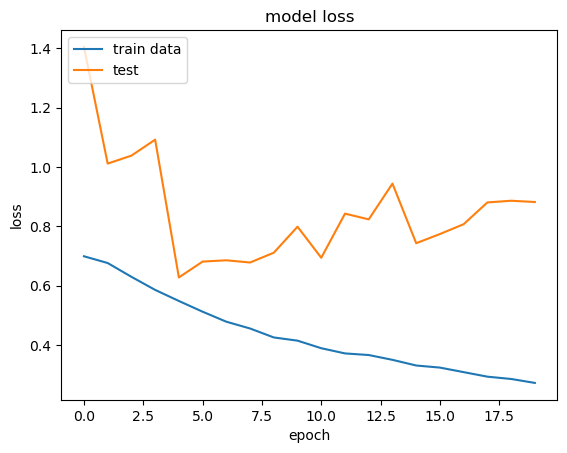

In [32]:
#Loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train data', 'test'], loc='upper left')
plt.show()


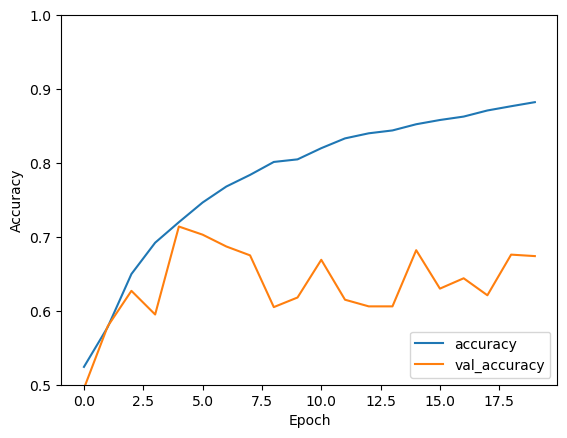

In [33]:
#Accuracy graph
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [34]:
y_pred = conv_model.predict(x_test)
y_pred_labels = np.round(y_pred)
print('Accuracy: ', accuracy_score(y_test, y_pred_labels))

32/32 [==============================] - 2s 63ms/step
Accuracy:  0.831


# Save model

In [35]:
#save_model(conv_model,'final_model.h5')
conv_model.save('final_model.h5')